In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

### Import Data

In [2]:
df = pd.read_csv(r'.\data\stock_prices_sample.csv')
df = df[df.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']
df.reset_index(drop = True, inplace =True)

### Defining Inputs

In [3]:
TRAIN_SPLIT=700

features_considered = ["CLOSE"]
LOOK_BACK = 90
NUM_OF_FUTURE_PREDICTION = 60


BATCH_SIZE = 128
EPOCHS = 30
EVALUATION_INTERVAL = 20
VALIDATION_INTERVAL = 10

### Data preprocessing

In [4]:
features = df[features_considered]
data = features.values

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)


In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [7]:
x_train, y_train = multivariate_data(dataset=dataset
                                     , target=dataset[:, 0]
                                     , start_index=0
                                     , end_index=TRAIN_SPLIT
                                     , history_size=LOOK_BACK
                                     , target_size=NUM_OF_FUTURE_PREDICTION)

x_val, y_val = multivariate_data(dataset=dataset
                                 , target=dataset[:, 0]
                                 , start_index=TRAIN_SPLIT
                                 , end_index=None
                                 , history_size=LOOK_BACK
                                 , target_size=NUM_OF_FUTURE_PREDICTION)

print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape)
print("shape of y_val:", y_val.shape)

shape of x_train: (610, 90, 1)
shape of y_train: (610, 60)
shape of x_val: (145, 90, 1)
shape of y_val: (145, 60)


### RNN LSTM Encoder & Decoder Network

In [8]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(LSTM(16, activation='relu'))
model.add(Dense(NUM_OF_FUTURE_PREDICTION))

model.compile(optimizer=RMSprop(clipvalue=1.0), loss='mean_squared_error')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Trining

In [9]:
model_history = model.fit(x=x_train, y=y_train
                          , epochs=EPOCHS
                          , steps_per_epoch=EVALUATION_INTERVAL
                          , validation_data=(x_val, y_val)
                          , validation_steps=VALIDATION_INTERVAL)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20 samples, validate on 145 samples
Epoch 1/30
20/20 [==============================] - 23s 1s/step - loss: 213.1363 - val_loss: 0.1806
Epoch 2/30
20/20 [==============================] - 22s 1s/step - loss: 0.1042 - val_loss: 0.1734
Epoch 3/30
20/20 [==============================] - 25s 1s/step - loss: 0.0968 - val_loss: 0.1573
Epoch 4/30
20/20 [==============================] - 28s 1s/step - loss: 0.0818 - val_loss: 0.1320
Epoch 5/30
20/20 [==============================] - 24s 1s/step - loss: 0.0604 - val_loss: 0.0950
Epoch 6/30
20/20 [==============================] - 28s 1s/step - loss: 0.0360 - val_loss: 0.0663
Epoch 7/30
20/20 [==============================] - 31s 2s/step - loss: 0.0228 - val_loss: 0.0538
Epoch 8/30
20/20 [==============================] - 23s 1s/step - loss: 0.0151 - val_loss: 0.0454
Epoch 9/30
20/20 [==============================] - 24s 1s/step - loss: 0.0

### Train & CV Error (curve by epoch)

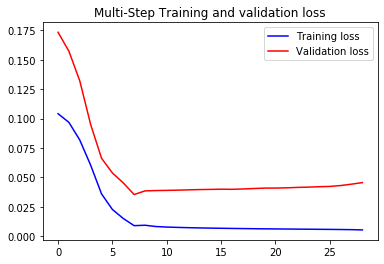

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(model_history, 'Multi-Step Training and validation loss')


### Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 60)                1020      
Total params: 8,508
Trainable params: 8,508
Non-trainable params: 0
_________________________________________________________________


### Visualizing

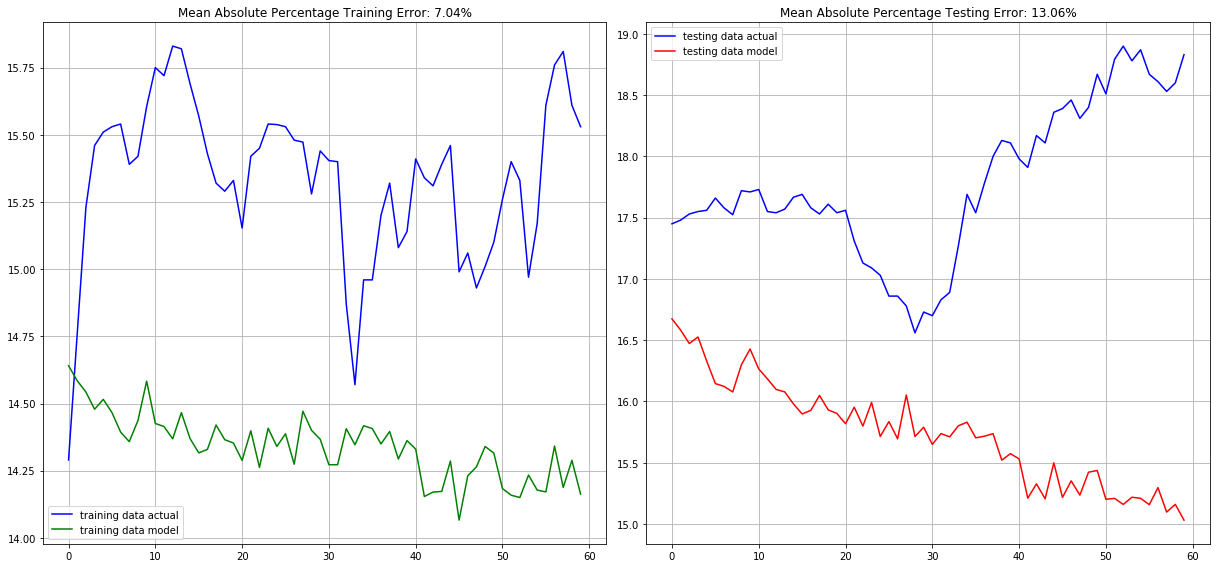

In [12]:
# make predictions
trainPredict = model.predict(x_train)
cvPredict = model.predict(x_val)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
cvPredict = scaler.inverse_transform(cvPredict)

trainY = scaler.inverse_transform(y_train)
cvY = scaler.inverse_transform(y_val)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

if NUM_OF_FUTURE_PREDICTION == 1:
    trainError = mean_absolute_percentage_error(trainPredict, trainY)
    testError = mean_absolute_percentage_error(cvPredict, cvY)
    layout = (1,2)
    plt.figure(figsize=(17, 8))
    plt.subplot2grid(layout, (0,0))
    plt.plot(trainY, color='b', label='training data actual')
    plt.plot(trainPredict , color='g', label='training data model')
    plt.legend()
    plt.grid(True)
    plt.title('Mean Absolute Percentage Training Error: {0:.2f}%'.format(trainError))
    plt.subplot2grid(layout, (0,1))
    plt.plot(cvY, color='b', label='testing data actual')
    plt.plot(cvPredict , color='r', label='testing data model')
    plt.title('Mean Absolute Percentage Testing Error: {0:.2f}%'.format(testError))
    plt.legend()
    plt.grid(True);
    plt.tight_layout()
else:
    trainError = mean_absolute_percentage_error(trainPredict[-1], trainY[-1])
    testError = mean_absolute_percentage_error(cvPredict[-1], cvY[-1])
    layout = (1,2)
    plt.figure(figsize=(17, 8))
    plt.subplot2grid(layout, (0,0))
    plt.plot(trainY[-1], color='b', label='training data actual')
    plt.plot(trainPredict[-1] , color='g', label='training data model')
    plt.legend()
    plt.grid(True)
    plt.title('Mean Absolute Percentage Training Error: {0:.2f}%'.format(trainError))
    plt.subplot2grid(layout, (0,1))
    plt.plot(cvY[-1], color='b', label='testing data actual')
    plt.plot(cvPredict[-1] , color='r', label='testing data model')
    plt.title('Mean Absolute Percentage Testing Error: {0:.2f}%'.format(testError))
    plt.legend()
    plt.grid(True);
    plt.tight_layout()